In [65]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sci
%matplotlib inline
def loadFile(fileName):
  with open(fileName, 'r') as f:
    filedata = f.read()
    return filedata

# Split data into packets
def parseData(file, transmitterIDs, angleOffset, timeOffset):
    splitFile = file[54:].split('\n\n')
    splitFile = splitFile[1:len(splitFile)-1]
    data = []
    for i in range(len(splitFile)):
      if(len(splitFile[i]) == 29) and splitFile[i][27:28] in transmitterIDs:
        dataPoint = []
        dataPoint.append(-int(splitFile[i][7:9])) # RSSI
        dataPoint.append(splitFile[i][27:28]) # ID
        dataPoint.append(int(int(splitFile[i][23:25] + splitFile[i][26:27], 16))) # Angle (need to normalise between 0 and 359 degrees)
        dataPoint.append(int(splitFile[i][14:16] + splitFile[i][17:19] + splitFile[i][20:22], 16) - timeOffset) # Relative time (not used in this notebook)
        data.append(dataPoint)

    # Standardize the angles
    maximum = max([x[2] for x in data])
    minimum = min([x[2] for x in data])
    for x in range(len(data)):
      data[x][2] = 359 *  ((data[x][2] - minimum) / (maximum-minimum))

    for x in range(len(data)):
      data[x][2] = np.deg2rad((data[x][2] + angleOffset) % (maximum+1))

    return data

def prepdata(filename, offset, timeoffset, id):
    transmitterProfile = np.array(parseData(loadFile(filename), ['a','b','c','d','e','f'],offset, timeoffset))
    data = transmitterProfile[transmitterProfile[:,1]==id][:,[0,2,3]].astype(float)
    data = data[np.argsort(data[:,-1]),:]
    return data

train_data = prepdata("no rf amp experiments/noamploc2long.log", 38, 0, 'd')
test_data = prepdata("/Users/chris/Desktop/Jul26- Two One-Antenna Transmitters/Path 1/pathtest1.log", 0, 0, 'a')


In [67]:
def getsample(data,time):
    times = np.array([time-300,time-100,time+100,time+300,time])
    idxs = np.argmin(np.abs(data[:,-1:]-times[None,:]),0)
    sigs = data[idxs,0]
    signaldiffs = sigs[:-1]-sigs[-1]
    
    #signaldiffs = np.array([data[idxs[0],0]-data[idxs[1],0],data[idxs[2],0]-data[idxs[1],0]])
    return signaldiffs,data[idxs,1][-1],data[idxs,0]

def build_training_record(data):
    record = []
    mint,maxt = np.min(data[:,-1]),np.max(data[:,-1])
    #avgss = [1000]*20
    for i,t in enumerate(np.arange(mint+100e3,maxt,50)):
        #del avgss[:3]
        #avgss.extend(list(rawss))
        signalstrengths,angle,rawss = getsample(data,t)
        #if np.mean(rawss)<np.mean(avgss)+3: continue ### IS IT A GOOD IDEA TO REMOVE FROM THE TRAINING SIGNALS THAT <3dB ABOVE AVG??!?
        record.append([t]+list(signalstrengths)+[angle])
        #print(angle)
        if i%1000==0:
            print(t-mint,maxt-mint)
    return np.array(record)

record = build_training_record(train_data)

100000.0 733482.0
150000.0 733482.0
200000.0 733482.0
250000.0 733482.0
300000.0 733482.0
350000.0 733482.0
400000.0 733482.0
450000.0 733482.0
500000.0 733482.0
550000.0 733482.0
600000.0 733482.0
650000.0 733482.0
700000.0 733482.0


In [68]:
#print(record)

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


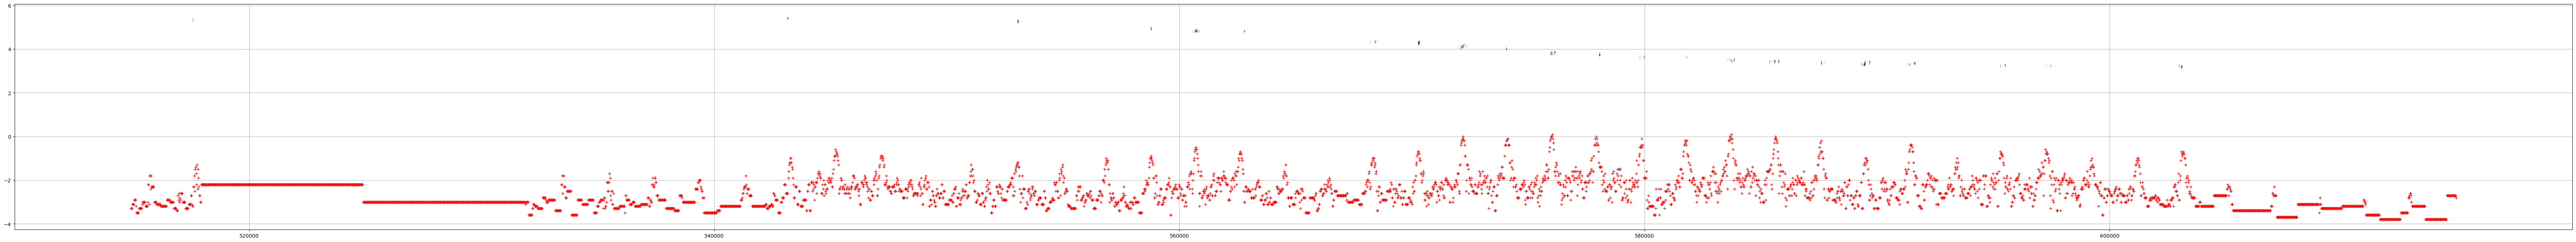

In [69]:
plt.figure(figsize=[90,8])
def compute_predictions(data,record):
    mint,maxt = np.min(data[:,-1]),np.max(data[:,-1])
    predictions = []
    avgss = [1000]*20
    for i,t in enumerate(np.arange(mint+0e3,mint+100e3,20)):    
        ss,ang,rawss = getsample(data,t)
        del avgss[:1]
        #avgss.extend(list(rawss))
        avgss.append(rawss[-1])

        select = np.all(np.abs(ss-record[:,1:-1])<6,1) #all 5 measurements must be <6 dB out
        #select = np.sum(np.abs(ss-record[:,1:-1]),1)<10 #sum of errors <10dB
        predangle = record[select,-1] 
        #print(ang)
        predangle -= ang
        predangle[predangle<0] += np.pi*2
        predangle[predangle>2*np.pi] -= np.pi*2
        predangle = 2*np.pi - predangle
        #predangle[predangle<0] += np.pi*2
        #predangle[predangle>2*np.pi] -= np.pi*2
        
        #plt.plot(t,ang,'.b',markersize=1)
        plt.plot(t,(rawss[-1]+60)/10,'r+')

        #if np.mean(rawss[-1])<np.mean(avgss)+4: continue
        #if len(predangle)<10: continue
        if (np.std(predangle)>0.05): continue

        
        #predangle = [(i + ang) % (np.pi*2) for i in predangle]
        #print(np.mean(predangle))
        plt.plot(np.repeat(t,len(predangle)),predangle,'.k',markersize=3,alpha=0.01)
        predictions.append([t,np.mean(predangle)])
    return predictions
   
predictions = compute_predictions(test_data,record)
plt.grid()
plt.savefig('a.pdf')

In [70]:
predictions

[[517579.0, 5.321667555626346],
 [517679.0, nan],
 [517759.0, nan],
 [533499.0, 2.181661564992912],
 [543159.0, 5.430846034496786],
 [553059.0, 5.267283314984266],
 [554979.0, 5.358160803622591],
 [558779.0, 4.942127428663508],
 [560559.0, 4.79410212263715],
 [560659.0, 4.810200140548539],
 [560699.0, 4.851469905152988],
 [560739.0, 4.8161391081421305],
 [560759.0, 4.838750818229078],
 [560839.0, 4.8157661745412765],
 [560859.0, 4.860741966804207],
 [562779.0, 4.821297525709136],
 [562799.0, 4.818199566286847],
 [568199.0, 4.27202898449689],
 [568219.0, 4.359444620536947],
 [568419.0, 4.327689324424274],
 [568499.0, 4.36768645311581],
 [568519.0, 4.348051499030873],
 [570279.0, 4.268750637959155],
 [570299.0, 4.306249589482651],
 [572019.0, 4.0612469132944975],
 [572039.0, 4.178318229274425],
 [572119.0, 4.090477354515825],
 [572139.0, 4.109003724695222],
 [572179.0, 4.136070465525119],
 [572219.0, 4.12673405360437],
 [572239.0, 4.202469812437157],
 [572319.0, 4.116795373141624],
 [572

In [5]:
summary = np.array([[trueang, np.mean(preds)] for trueang, preds in predictions])

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


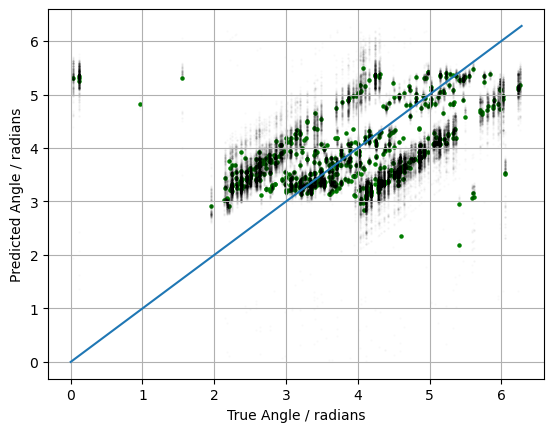

In [6]:
plt.scatter(summary[:,0],summary[:,1],5,color='green')
for trueang, preds in predictions:
    plt.scatter(np.repeat(trueang,len(preds)),preds,1,color='black',alpha=0.01)
#plt.plot([2.5,4.5],[2.5,4.5])
#plt.xlim([2.5,4])
#plt.ylim([2.5,4])
plt.plot([0,2*np.pi],[0,2*np.pi])
plt.xlabel('True Angle / radians')
plt.ylabel('Predicted Angle / radians')
plt.grid()

In [105]:
np.rad2deg(np.mean(np.abs(summary[:,1]-summary[:,0]))) #MAE is 1.78 degrees!

14.207683192650192